In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS

# Load data
df = pd.read_csv("../raw_data/cleansed_reviews.csv")

# Convert timestamp
df['time'] = pd.to_datetime(df['time'], unit='s')

# Check for missing data
missing_data = df.isnull().sum()

# Descriptive statistics
ratings_distribution = df['rating'].value_counts()


# Distribution of Ratings

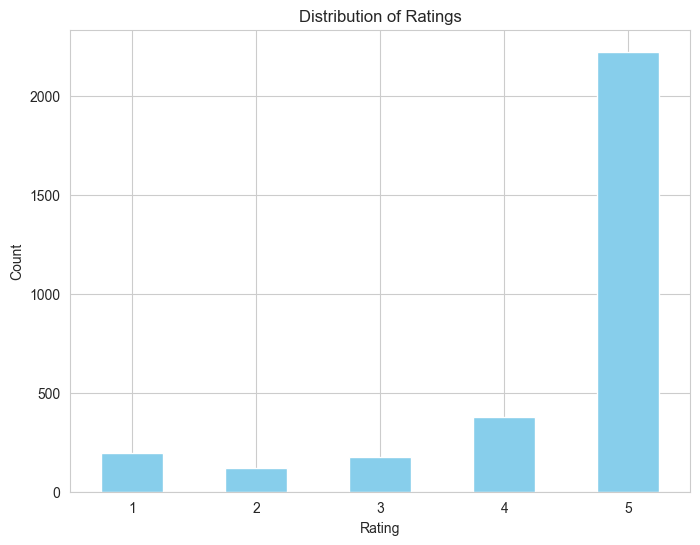

In [2]:
# Plot ratings distribution
plt.figure(figsize=(8, 6))
ratings_distribution.sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Distribution of Review Lengths

<Axes: title={'center': 'Distribution of Review Lengths'}, ylabel='Frequency'>

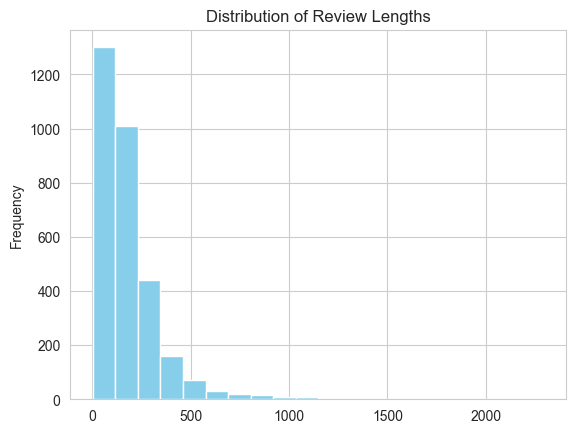

In [3]:
df['review_length'] = df['text'].str.len()
df['review_length'].plot(kind='hist', bins=20, title='Distribution of Review Lengths', color='skyblue')

# Review Length Distribution by Rating

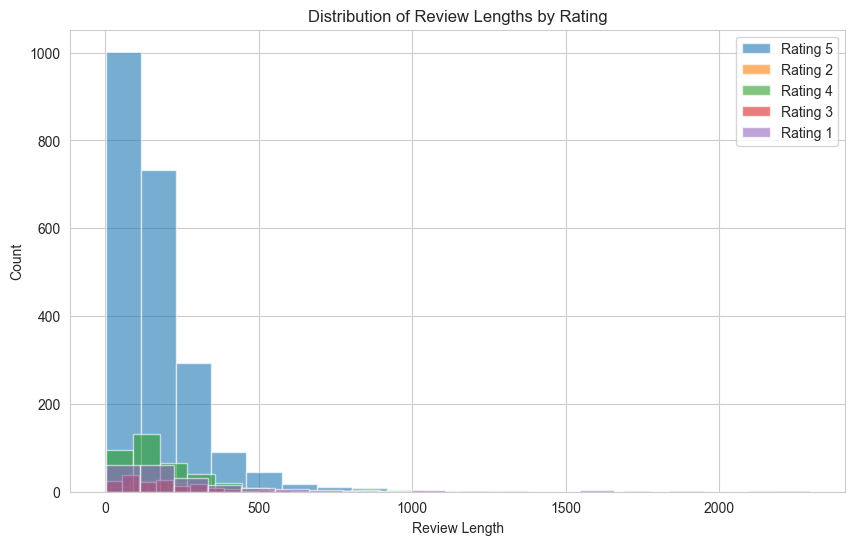

In [4]:
# Plot review length distribution by rating
plt.figure(figsize=(10, 6))
for rating in df['rating'].unique():
    subset = df[df['rating'] == rating]
    subset['review_length'].plot(kind='hist', bins=20, alpha=0.6, label=f'Rating {rating}')
    
plt.title('Distribution of Review Lengths by Rating')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.legend()
plt.show()

# Average Rating Over Time

/var/folders/bf/yds996dn4h3d3zytfpz42rnc0000gn/T/ipykernel_7290/522738567.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('time')['rating'].resample('M').mean().plot(title='Average Rating Over Time', color='skyblue')


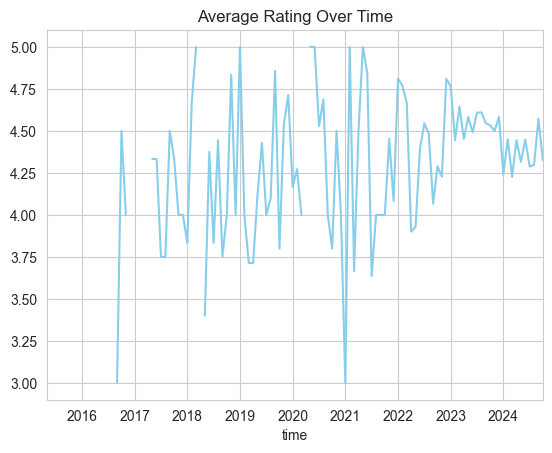

In [5]:
df['time'] = pd.to_datetime(df['time'], unit='s')  # Konwersja timestampu
df.set_index('time')['rating'].resample('M').mean().plot(title='Average Rating Over Time', color='skyblue')
plt.show()


# Sentiment Analysis

/var/folders/bf/yds996dn4h3d3zytfpz42rnc0000gn/T/ipykernel_7290/1483168937.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sentiment_distribution = df[['food', 'service', 'atmosphere']].apply(pd.value_counts)
/var/folders/bf/yds996dn4h3d3zytfpz42rnc0000gn/T/ipykernel_7290/1483168937.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sentiment_distribution = df[['food', 'service', 'atmosphere']].apply(pd.value_counts)
/var/folders/bf/yds996dn4h3d3zytfpz42rnc0000gn/T/ipykernel_7290/1483168937.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sentiment_distribution = df[['food', 'service', 'atmosphere']].apply(pd.value_counts)


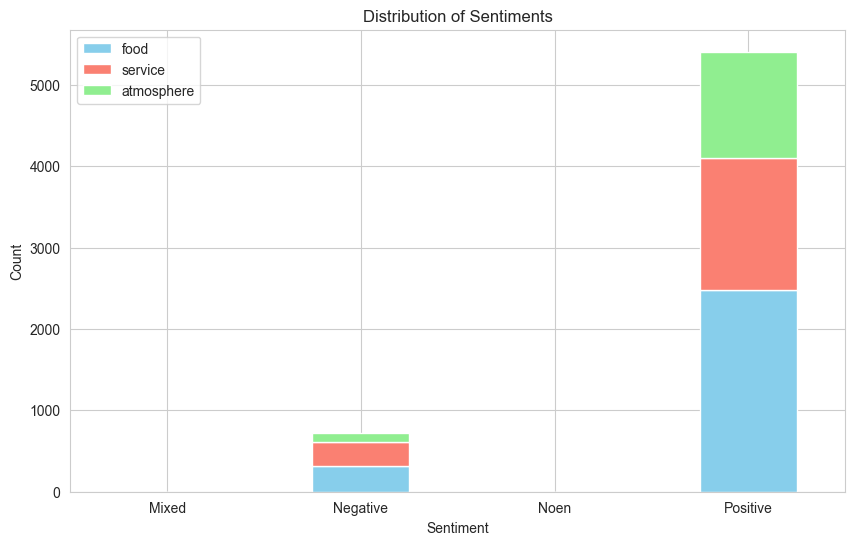

In [6]:
# Plot sentiment distribution
sentiment_distribution = df[['food', 'service', 'atmosphere']].apply(pd.value_counts)
sentiment_distribution.plot(kind='bar', stacked=True, color=['skyblue', 'salmon', 'lightgreen'], figsize=(10, 6))
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


# Word Cloud for Sentiment Analysis
Purpose:

This section generates a word cloud to visualize the most frequently occurring terms in reviews associated with a specific sentiment (e.g., "Positive" for food).

Highlight Common Terms: It helps quickly identify the most frequent and relevant words tied to a particular sentiment.
Sentiment-Specific Insights: Analyzing positive, negative, or other sentiments separately reveals how language usage varies across sentiments.
How It Works:

1. Filtering Reviews: Selects reviews matching the specified sentiment in the target category.
2. Preprocessing: Converts text to lowercase and combines all tokens into a single text corpus.
3. Visualization: Creates a word cloud, where term sizes represent their frequency.

This visualization provides an intuitive summary of the key terms associated with specific sentiments, offering insights into language patterns and customer feedback.

In [8]:
from wordcloud import WordCloud, STOPWORDS

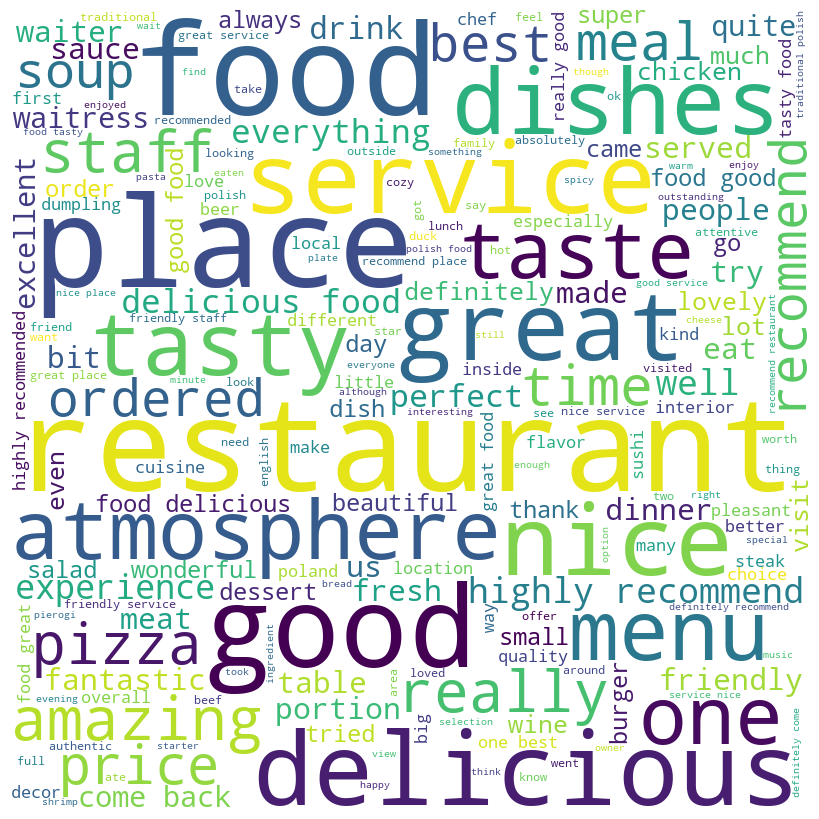

In [9]:
# Generate word cloud
def word_cloud_plot(df, sentiment_col, sentiment_value):
    comment_words = ' '
    stopwords = set(STOPWORDS)
    filtered_reviews = df[df[sentiment_col] == sentiment_value]['text'].dropna()

    for review in filtered_reviews:
        tokens = str(review).lower().split()
        comment_words += ' '.join(tokens) + ' '

    wordcloud = WordCloud(width=800, height=800, 
                          background_color='white', 
                          stopwords=stopwords, 
                          min_font_size=10).generate(comment_words)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

# Example: Generate word cloud for positive food reviews
word_cloud_plot(df, 'food', 'Positive')

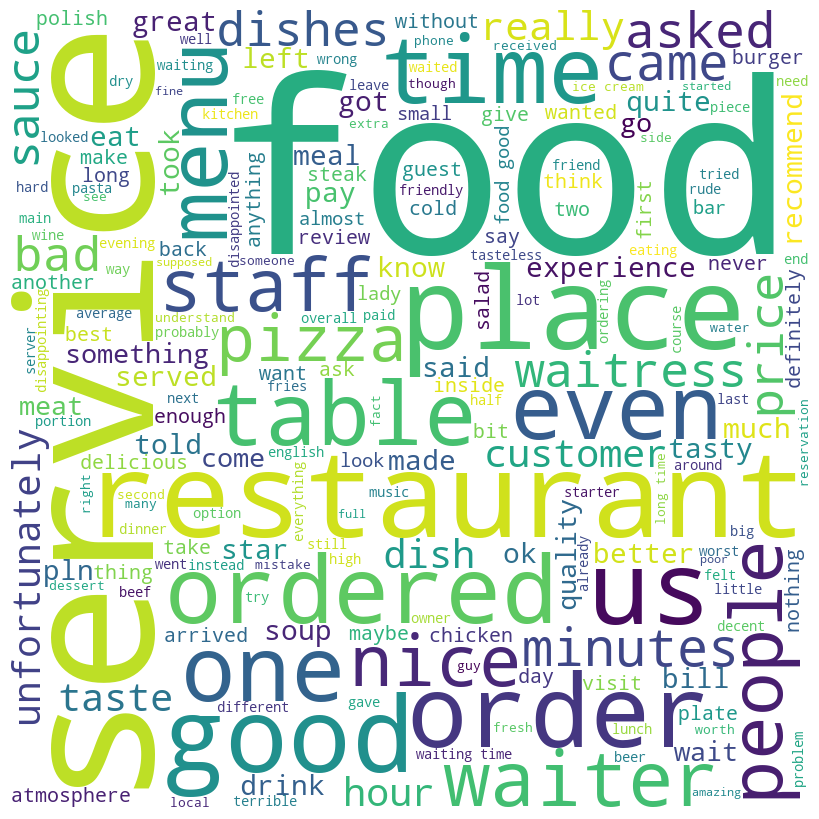

In [10]:
word_cloud_plot(df, 'service', 'Negative')

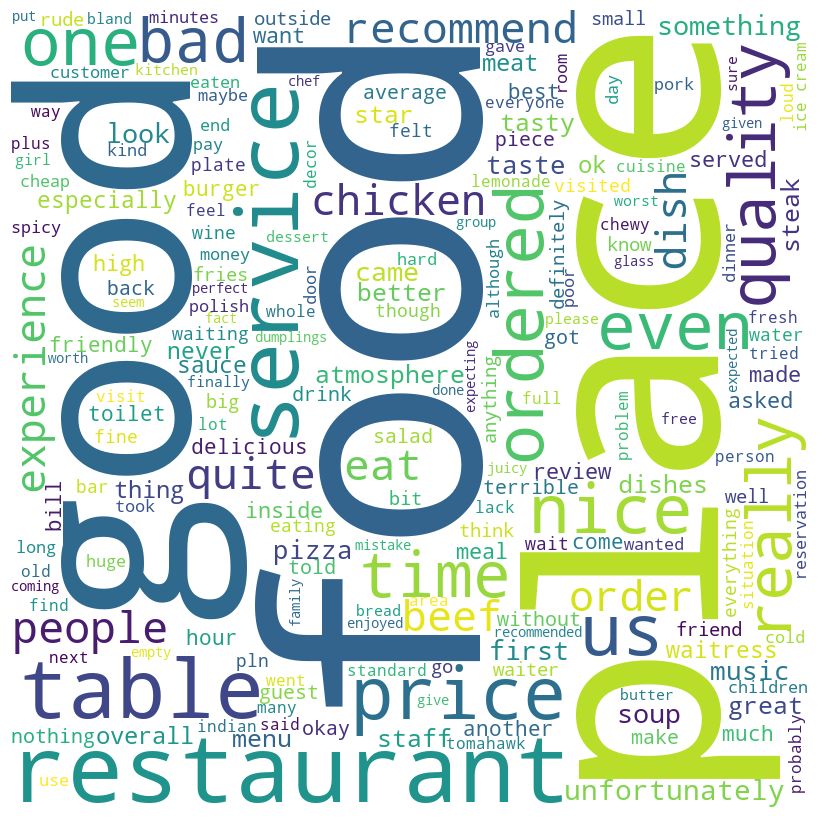

In [11]:
word_cloud_plot(df, 'atmosphere', 'Negative')

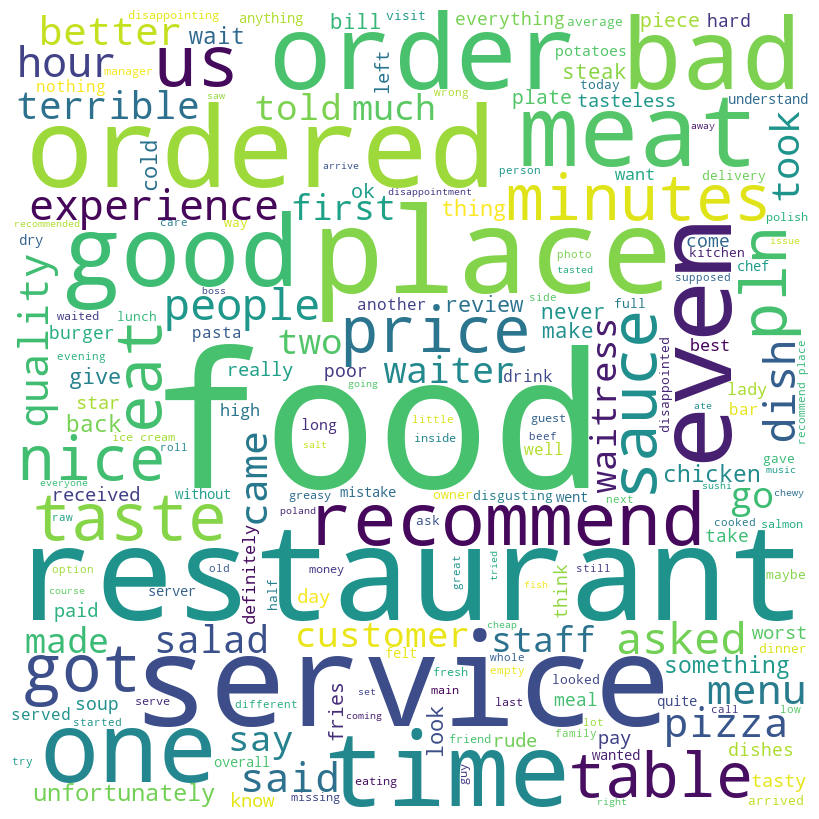

In [12]:
# word cloud for reviews with one star
word_cloud_plot(df, 'rating', 1)

# Analyzing and Visualizing Top TF-IDF Terms
Purpose:

This section identifies and visualizes the top terms based on their TF-IDF scores. TF-IDF helps determine the importance of words or phrases by balancing their frequency in individual reviews with their rarity across all reviews.

Identify Key Features: The most important terms help understand dominant themes or sentiments in the dataset.
Guide Further Analysis: High-scoring terms can inform feature selection for machine learning models.
How It Works:

1. TF-IDF Vectorization: Transforms the cleaned text into numerical features, focusing on the top 50 terms with unigrams and bigrams.
2. Summarization: Computes the sum of TF-IDF scores for each term across all reviews.
3. Visualization: Displays the top 10 terms as a bar chart, showing their relative importance.

This analysis provides insights into the dataset’s linguistic patterns and highlights terms likely to influence sentiment or topic classification.

Top 10 terms by TF-IDF scores:
food          433.082516
good          320.210588
place         301.077081
service       293.676573
nice          261.255955
great         259.759207
restaurant    248.820316
delicious     243.460317
recommend     226.504333
tasty         185.603671
dtype: float64


/var/folders/bf/yds996dn4h3d3zytfpz42rnc0000gn/T/ipykernel_7290/1051511385.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_terms.values, y=top_terms.index, palette='viridis')


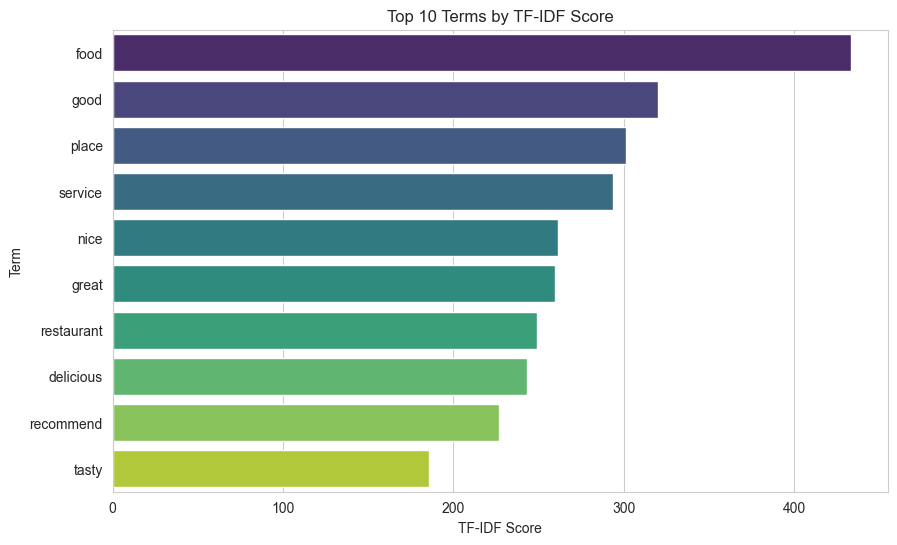

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("../raw_data/clensed_reviews.csv")

# Preprocess text
def preprocess_text(text):
    # Remove punctuation, convert to lowercase
    return " ".join(word.lower() for word in str(text).split() if word.isalpha())

df['cleaned_text'] = df['text'].apply(preprocess_text)

# Generate TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=50, ngram_range=(1, 2))  # You can adjust max_features and ngram_range
tfidf_matrix = vectorizer.fit_transform(df['cleaned_text'])

# Convert to DataFrame for analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Summarize top terms
top_terms = tfidf_df.sum(axis=0).sort_values(ascending=False).head(10)
print("Top 10 terms by TF-IDF scores:")
print(top_terms)

# Visualize top terms
plt.figure(figsize=(10, 6))
sns.barplot(x=top_terms.values, y=top_terms.index, palette='viridis')
plt.title('Top 10 Terms by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Term')
plt.show()


# Word Cloud Visualization of TF-IDF Terms
Purpose:

This section uses a word cloud to visualize the most important terms based on their TF-IDF weights. TF-IDF assigns higher weights to terms that are frequent in individual documents but rare across the entire dataset, highlighting their relevance.

Intuitive Representation: Word clouds provide a quick and visually appealing way to understand the most influential terms.
Feature Insights: By scaling term sizes based on their weights, this visualization emphasizes terms with the highest impact on the dataset.
How It Works:

1. Input: A dictionary of terms and their corresponding TF-IDF weights.
2. Output: A word cloud where term sizes reflect their importance.
3. Interpretation: Larger terms in the word cloud are more significant based on their TF-IDF scores.

This visualization helps interpret text data and identify key terms that are likely to influence downstream analysis or model predictions.

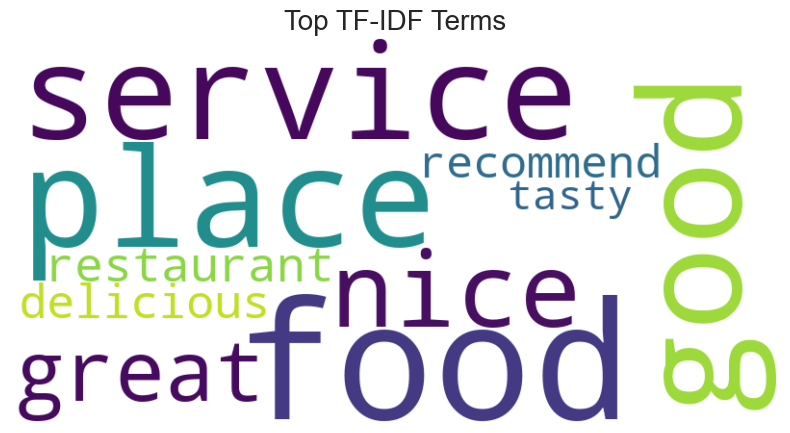

In [14]:
# Example: Generate word cloud with TF-IDF weights
def plot_tfidf_wordcloud(tfidf_df, title):
    term_weights = {term: weight for term, weight in tfidf_df.items()}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(term_weights)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Create word cloud for top terms
plot_tfidf_wordcloud(top_terms, "Top TF-IDF Terms")

# Identifying Most Correlated Terms
This section analyzes the most significant words and phrases (unigrams, bigrams, trigrams) correlated with target categories (e.g., "service" sentiment). Using TF-IDF for feature extraction and Chi-Squared for statistical analysis, we identify terms most strongly associated with each category.

This helps:

- Highlight important features for category differentiation.
- Provide insights into language patterns and text interpretation.
- Improve feature engineering and model performance.

The results offer a clearer understanding of how specific terms influence categorization and sentiment.

In [15]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# Load dataset
df = pd.read_csv("../raw_data/clensed_reviews.csv")

# Preprocess text
def preprocess_text(text):
    # Remove punctuation, convert to lowercase
    return " ".join(word.lower() for word in str(text).split() if word.isalpha())

df['cleaned_text'] = df['text'].apply(preprocess_text)

# Target category (example: 'food' sentiment)
categories = ['food', 'service', 'atmosphere']
for category_col in categories: 
    category_to_id = {cat: idx for idx, cat in enumerate(df[category_col].dropna().unique())}
    df['category_id'] = df[category_col].map(category_to_id)
    
    # Generate TF-IDF features
    tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)
    features = tfidf.fit_transform(df['cleaned_text'])
    labels = df['category_id']
    
    # Analyze top N correlated terms for each category
    N = 5  # Number of terms to display
    for category, category_id in category_to_id.items():
        features_chi2 = chi2(features, labels == category_id)
        indices = np.argsort(features_chi2[0])  # Sort features by chi-squared scores
        feature_names = np.array(tfidf.get_feature_names_out())[indices]
        
        # Extract unigrams, bigrams, and trigrams
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
        
        print(f"Most correlated terms with '{category}' sentiment in {category_col}:")
        print("  1. Most correlated unigrams:\n--> {}".format('\n--> '.join(unigrams[-N:])))
        print("  2. Most correlated bigrams:\n--> {}".format('\n--> '.join(bigrams[-N:])))
        print("  3. Most correlated trigrams:\n--> {}".format('\n--> '.join(trigrams[-N:])))
        print("___________________________________________________________________________\n")


Most correlated terms with 'Positive' sentiment in food:
  1. Most correlated unigrams:
--> terrible
--> delicious
--> super
--> bad
--> nan
  2. Most correlated bigrams:
--> highly recommend
--> food delicious
--> great food
--> tasty food
--> delicious food
  3. Most correlated trigrams:
--> definitely come back
--> highly recommend restaurant
--> would highly recommend
--> traditional polish food
--> food great service
___________________________________________________________________________

Most correlated terms with 'Negative' sentiment in food:
  1. Most correlated unigrams:
--> dry
--> frozen
--> tasteless
--> worst
--> bad
  2. Most correlated bigrams:
--> much better
--> highly recommend
--> waiting time
--> delicious food
--> could eat
  3. Most correlated trigrams:
--> would highly recommend
--> traditional polish food
--> highly recommend place
--> food great service
--> definitely come back
___________________________________________________________________________
Most